Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [12]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [13]:
## mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [14]:
!unzip /content/gdrive/MyDrive/CNN_assignment_suraj.zip

Archive:  /content/gdrive/MyDrive/CNN_assignment_suraj.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  inf

In [15]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [16]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [17]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [18]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed =123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [19]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed =123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [20]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [21]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

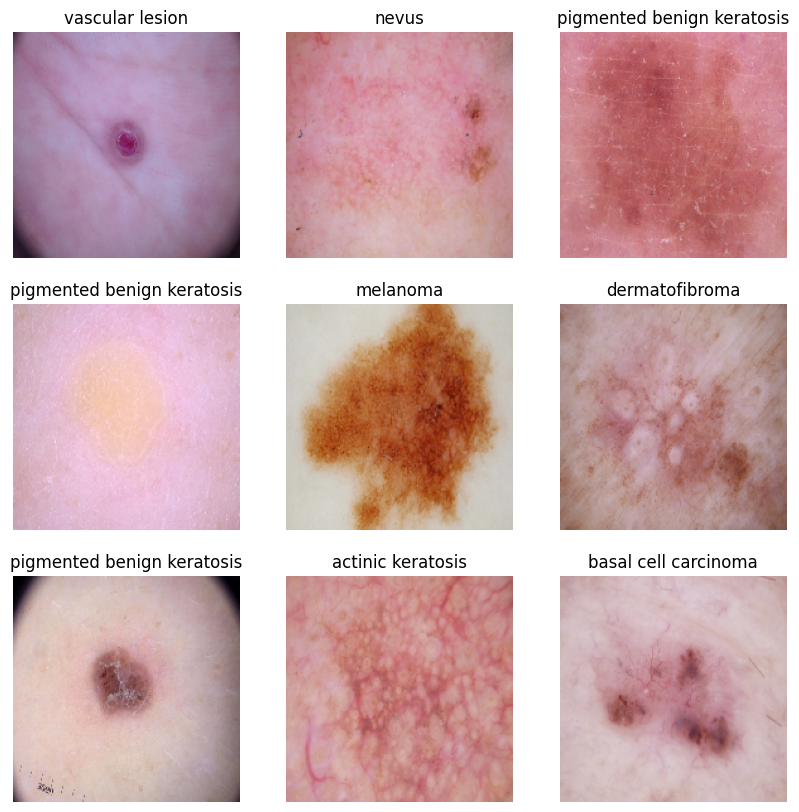

In [22]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [25]:
### Your code goes here
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015684064 0.8214536


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [26]:
# number of classes in dataset
num_classes = len(class_names)

# creating model with keras Sequential and relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [27]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

### Train the model

In [29]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 21s 160ms/step - loss: 3.0264 - accuracy: 0.1953 - val_loss: 2.0409 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.9011 - accuracy: 0.3013 - val_loss: 1.8464 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5660 - accuracy: 0.4531 - val_loss: 1.5114 - val_accuracy: 0.4944
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.3714 - accuracy: 0.5140 - val_loss: 1.6156 - val_accuracy: 0.4474
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.2442 - accuracy: 0.5530 - val_loss: 1.5685 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 4s 67ms/step - loss: 1.1036 - accuracy: 0.6105 - val_loss: 1.4578 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 0.9708 - accuracy: 0.6484 - val_loss: 1.5288 - val_accuracy: 0.5034
Epoch 8/20
56/56 [====

**Observations**

*   Training Loss: **~0.31**
*   Validation Loss: **~2.17**
*   Tranining Accuracy: **~0.88**
*   Validation Accuracy: **~0.51**

### Visualizing training results

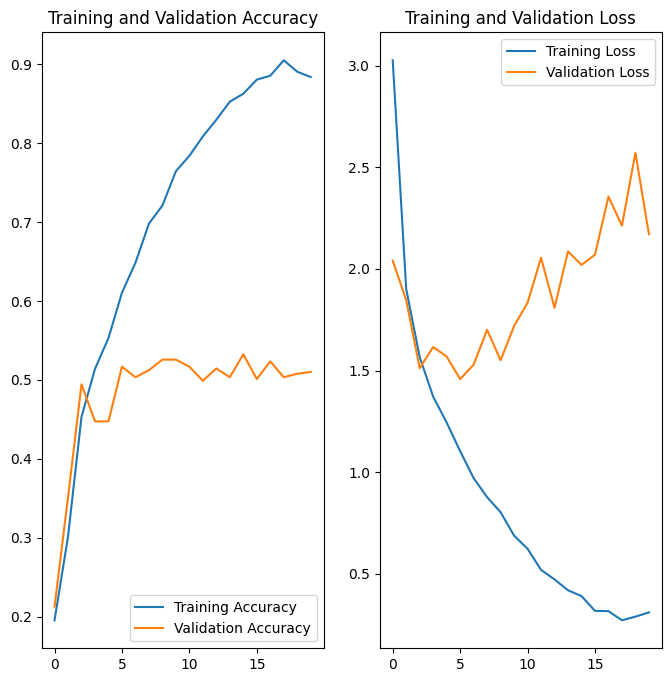

In [30]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

* Training accuracy is increasing linearly however Validation accuracy increases initially and then stall around 50-55 %
* Training loss decreases with epochs and the validation loss increases
* Plot shows the training accuracy and validation accuracy are of large margin.
* Difference between training and validation accuracy is notibeable

From the above findings we can conculde that this model is overfitted

### Write your findings here

In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

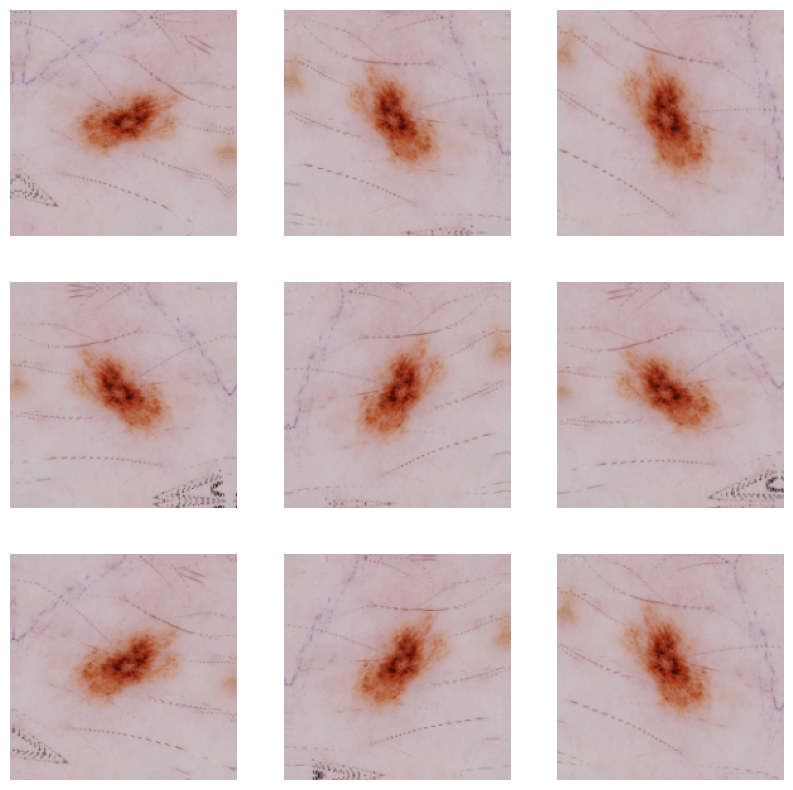

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [34]:
## Your code goes here
model = Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


### Compiling the model

In [35]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

### Training the model

In [36]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 76ms/step - loss: 2.6508 - accuracy: 0.2400 - val_loss: 1.9627 - val_accuracy: 0.2550
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.8362 - accuracy: 0.3482 - val_loss: 1.6762 - val_accuracy: 0.4116
Epoch 3/20
56/56 [==============================] - 4s 70ms/step - loss: 1.5817 - accuracy: 0.4319 - val_loss: 1.6590 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.5500 - accuracy: 0.4470 - val_loss: 1.5298 - val_accuracy: 0.4877
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.4722 - accuracy: 0.4660 - val_loss: 1.4614 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3983 - accuracy: 0.5056 - val_loss: 1.4806 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 4s 70ms/step - loss: 1.3218 - accuracy: 0.5262 - val_loss: 1.4378 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing the results

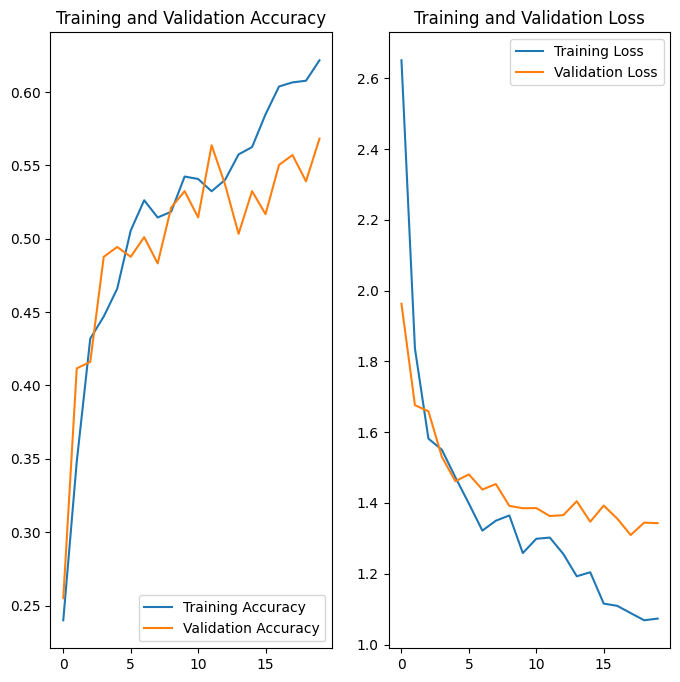

In [37]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

* Training accuracy increased linearly over time, however the validation accuracy increases and stall around 55% accuracy.
* Training loss decreased with epochs, validation loss decreases initially amd stalls around 1.5
* Slight difference in accuracy between training and validation is still there which is a sign of overfitting

In [38]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
model = Sequential([
  layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

In [40]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 113ms/step - loss: 3.3708 - accuracy: 0.2623 - val_loss: 1.8483 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - 6s 110ms/step - loss: 1.6894 - accuracy: 0.3856 - val_loss: 1.6094 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 1.5597 - accuracy: 0.4515 - val_loss: 1.4553 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 6s 111ms/step - loss: 1.4718 - accuracy: 0.4944 - val_loss: 1.4727 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 6s 108ms/step - loss: 1.4283 - accuracy: 0.4994 - val_loss: 1.4366 - val_accuracy: 0.5347
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 1.4259 - accuracy: 0.5084 - val_loss: 1.5155 - val_accuracy: 0.4676
Epoch 7/20
56/56 [==============================] - 6s 108ms/step - loss: 1.3657 - accuracy: 0.5201 - val_loss: 1.4191 - val_accuracy: 0.5123
Epoch 

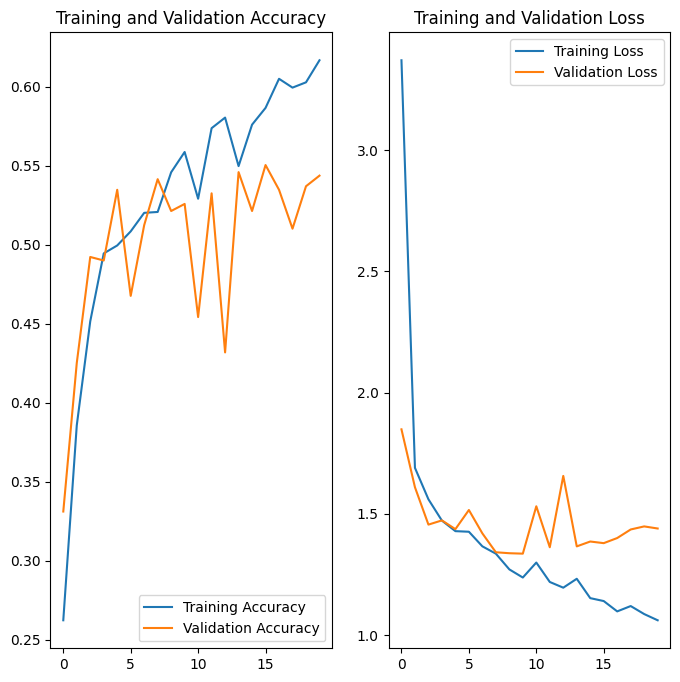

In [41]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 200x200 with 0 Axes>

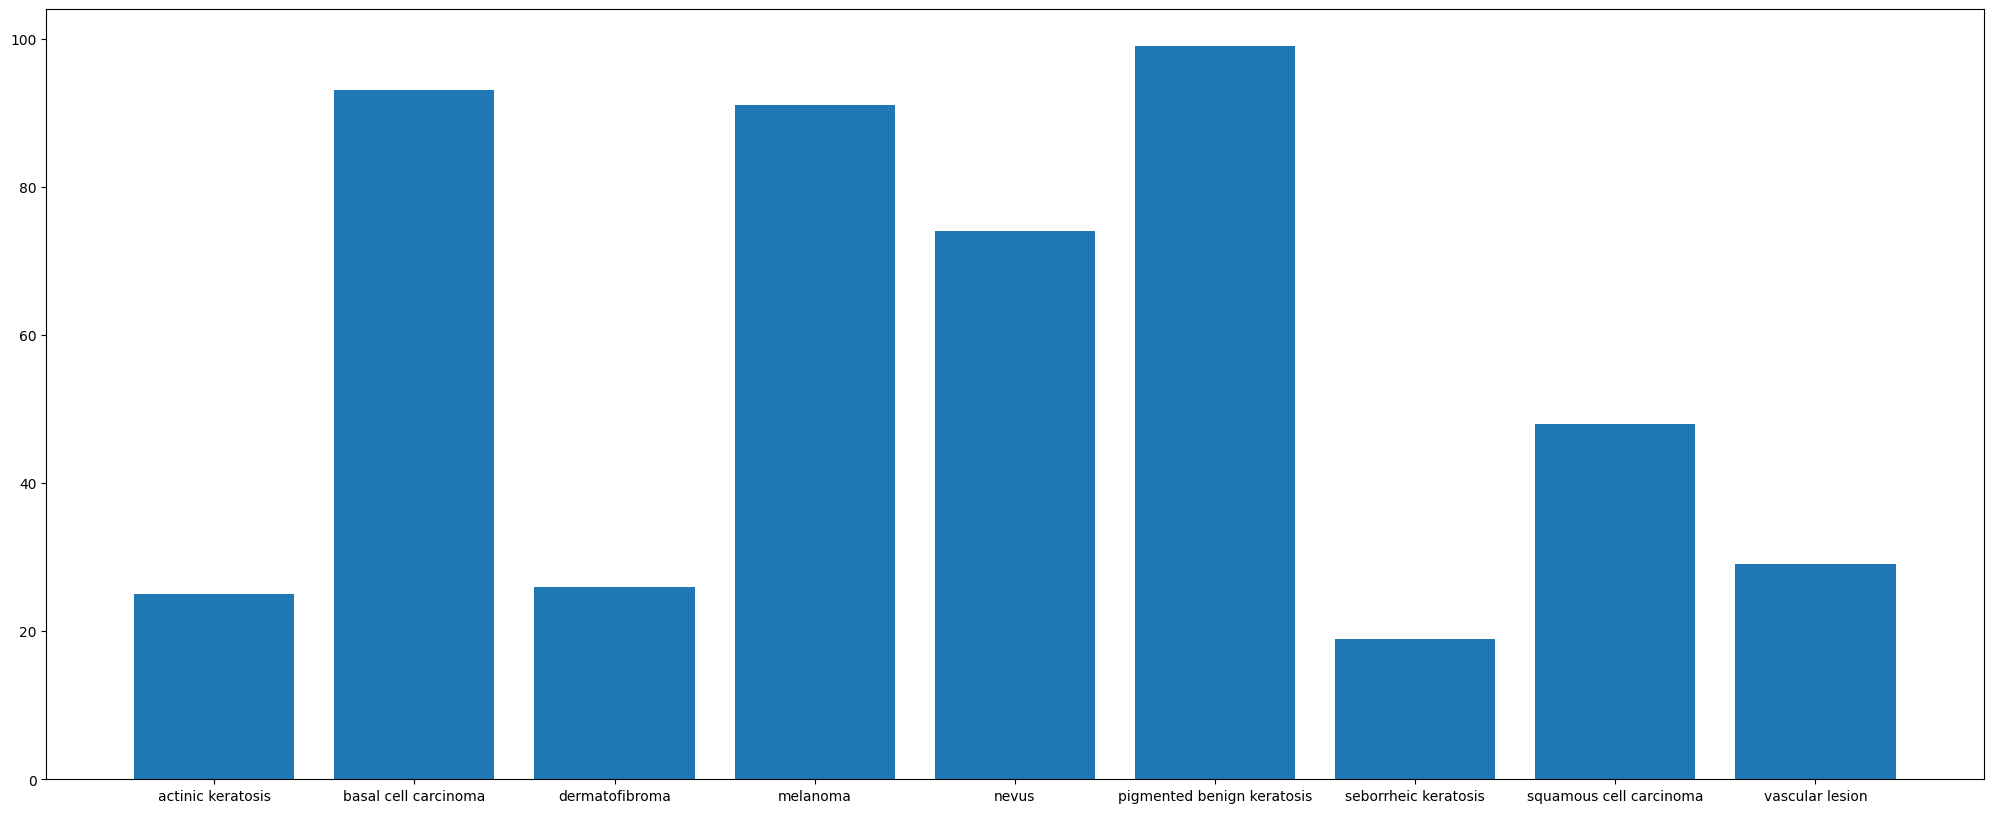

In [42]:
## Your code goes here.
# Let's check on the Class Imbalance if Present
# taking empty dictionary
class_data = dict()

# adding the empty lists for each class record in the dictionary
for i in class_names:
  class_data[i] = []

# setting the output image size
plt.figure(figsize=(2, 2))
# adding the images into the data dictionary for each class
for images, labels in train_ds:
  for i in range(9):
    class_data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
# storing the number of images for specific class
for i in class_data:
  # getting the length and storing the dictionary
  class_data[i] = len(class_data[i])

f = plt.figure(figsize=(10, 10))
f.set_figwidth(25)
f.set_figheight(10)
# printing the plot
plt.bar(range(len(class_data)), list(class_data.values()), align='center')
plt.xticks(range(len(class_data)), list(class_data.keys()))
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
Answer: **seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
Answer: **pigmented benign keratosis**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [45]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3AC011A830>: 100%|██████████| 500/500 [00:15<00:00, 32.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A39D23C10>: 100%|██████████| 500/500 [00:15<00:00, 31.29 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A39ED1960>: 100%|██████████| 500/500 [00:15<00:00, 31.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F3AC010AF80>: 100%|██████████| 500/500 [01:12<00:00,  6.85 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F3AC00E1600>: 100%|██████████| 500/500 [01:22<00:00,  6.09 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3A39D56D10>: 100%|██████████| 500/500 [00:16<00:00, 30.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F3AC0118C70>: 100%|██████████| 500/500 [00:38<00:00, 13.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3AC010AB60>: 100%|██████████| 500/500 [00:16<00:00, 30.86 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3AC00B3DF0>: 100%|██████████| 500/500 [00:15<00:00, 31.66 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [47]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031799.jpg_51d22349-6cd6-4c4e-8229-bad64eced14a.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031344.jpg_c866e7d0-eb3f-44d7-824d-072de3a1a175.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033780.jpg_10e3e15a-fda5-49b5-a465-b8790e4c252c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027216.jpg_5c191af9-3f5b-48cb-a893-a633ae3c172f.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030021.jpg_976275fa-c4d9-4414-a91a-742b9cd1d58e.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [48]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [49]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [50]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [51]:
new_df['Label'].value_counts()

dermatofibroma                500
melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
squamous cell carcinoma       500
seborrheic keratosis          500
vascular lesion               500
nevus                         500
actinic keratosis             500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [52]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [53]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [54]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [55]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#normalizing the Data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))



0.21993493 0.98774517


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [56]:
# creating a model post handling the imbalancing
# number of classes in dataset
num_classes = len(class_names)

# creating model with keras Sequential and relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [57]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                  

#### **Todo:**  Train your model

In [58]:
# lets train the model with 30 epochs
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 28s 155ms/step - loss: 2.6877 - accuracy: 0.2919 - val_loss: 1.5940 - val_accuracy: 0.3638
Epoch 2/30
169/169 [==============================] - 19s 113ms/step - loss: 1.5389 - accuracy: 0.4253 - val_loss: 1.3470 - val_accuracy: 0.4944
Epoch 3/30
169/169 [==============================] - 18s 109ms/step - loss: 1.4233 - accuracy: 0.4605 - val_loss: 1.4108 - val_accuracy: 0.4618
Epoch 4/30
169/169 [==============================] - 18s 108ms/step - loss: 1.3231 - accuracy: 0.4952 - val_loss: 1.3438 - val_accuracy: 0.4848
Epoch 5/30
169/169 [==============================] - 19s 111ms/step - loss: 1.2957 - accuracy: 0.5032 - val_loss: 1.3021 - val_accuracy: 0.5100
Epoch 6/30
169/169 [==============================] - 18s 107ms/step - loss: 1.2568 - accuracy: 0.5122 - val_loss: 1.3095 - val_accuracy: 0.4633
Epoch 7/30
169/169 [==============================] - 18s 106ms/step - loss: 1.2280 - accuracy: 0.5236 - val_loss: 1.2040 - val_accuracy: 0.5

Results

* Training Loss: ~0.74
* Validation Loss: ~1.01
* Tranining Accuracy: ~0.71
* Validation Accuracy: ~0.64

#### **Todo:**  Visualize the model results

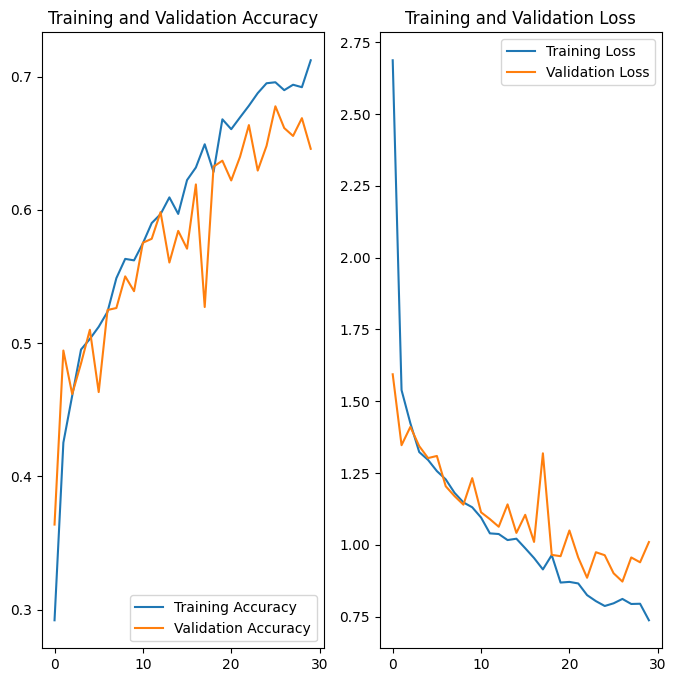

In [59]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

* **Yes we get rid of overfitting by using data augumentation and dropouts.**
* **However the accuracy was still not that great due to class imbalance.**
* **Class rebalance helped to improve the accuracy of the model**
